In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.preprocessing import text
from tensorflow.keras.layers import Activation, MaxPool1D, Input, Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.preprocessing import text as keras_text, sequence as keras_seq
from tensorflow.keras.layers import BatchNormalization

import nltk
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv('/kaggle/input/duplicate-question-pairs/train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [12]:
df.shape

(404290, 6)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


is_duplicate
0    255027
1    149263
Name: count, dtype: int64


<Axes: xlabel='is_duplicate'>

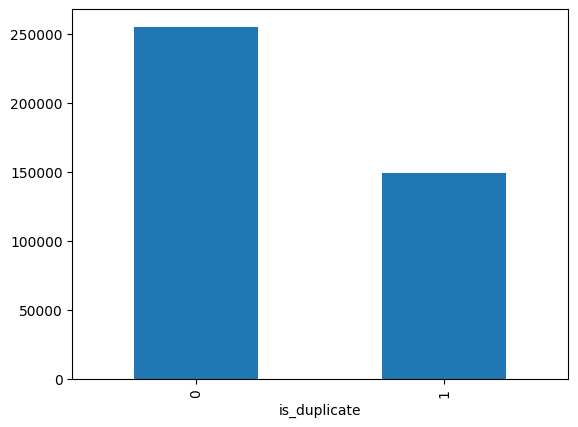

In [14]:
print(df['is_duplicate'].value_counts())
df['is_duplicate'].value_counts().plot(kind = 'bar')

In [15]:
label_1D = df['is_duplicate']

In [16]:
label_1D.head()

0    0
1    0
2    0
3    0
4    0
Name: is_duplicate, dtype: int64

In [17]:
q1 = df['question1'].astype(str)
q1.head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
Name: question1, dtype: object

In [18]:
q2 = df['question2'].astype(str)
q2.head()

0    What is the step by step guide to invest in sh...
1    What would happen if the Indian government sto...
2    How can Internet speed be increased by hacking...
3    Find the remainder when [math]23^{24}[/math] i...
4              Which fish would survive in salt water?
Name: question2, dtype: object

In [20]:
# fitting on a single tokenized object

from tensorflow.keras.preprocessing.text import Tokenizer
tokens = Tokenizer(filters='!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~', lower = True, char_level = False)
tokens.fit_on_texts(q1+q2)

In [21]:
vocabulary = len(tokens.word_counts)
vocabulary

89983

In [22]:
#Sequencing & Encoding
q1_encoded = tokens.texts_to_sequences(q1)
print(q1[0])
q1_encoded[0]

What is the step by step guide to invest in share market in india?


[2, 3, 1, 1222, 59, 1222, 2566, 7, 579, 8, 763, 384, 8, 36]

In [23]:
q2_encoded = tokens.texts_to_sequences(q2)
print(q2[0])
q2_encoded[0]

What is the step by step guide to invest in share market?


[2, 3, 1, 1222, 59, 1222, 2566, 7, 579, 8, 763, 384]

In [24]:
#padding
from keras.preprocessing import sequence
max_length = 100
q1_padded = sequence.pad_sequences(q1_encoded, maxlen = max_length, padding = 'pre')

In [25]:
from keras.preprocessing import sequence
max_length = 100
q2_padded = sequence.pad_sequences(q2_encoded, maxlen = max_length, padding = 'pre')

In [26]:
def commonWords():
   length_features = [[len(set(x1)), len(set(x2)), len(set(x1).intersection(x2))] for x1, x2 in zip(q1_encoded, q2_encoded)]
   length_features = np.array(length_features)
   return length_features
length_features= commonWords()

In [32]:
embeddings_dict = {}
with open("/kaggle/input/glove-6b-300d-txt/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector
print('Loaded %s word vectors' % len(embeddings_dict))

Loaded 400000 word vectors


In [33]:
embedding_matrix = np.zeros((vocabulary+1, 300))
for word, i in tokens.word_index.items():
  embedding_vector = embeddings_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [34]:
label_2D = to_categorical(df['is_duplicate'], num_classes=2)

In [35]:
VALIDATION_SPLIT = 0.3
RATE_DROP_LSTM = 0.17
RATE_DROP_DENSE = 0.25
NUMBER_DENSE_UNITS = 64
ACTIVATION_FUNC = 'relu'

In [36]:
from sklearn.model_selection import train_test_split
text_train_q1, text_test_q1, text_train_q2, text_test_q2, length_features_train, length_features_test, label_train, label_test = train_test_split(q1_padded, q2_padded, length_features, label_2D, test_size=0.3, random_state=42)

In [37]:
#MODEL

embedding_layer = (Embedding(vocabulary+1, 300, weights=[embedding_matrix], input_length = max_length, trainable=False))

lstm_layer = Bidirectional(LSTM(64, dropout =RATE_DROP_LSTM, recurrent_dropout=RATE_DROP_LSTM))

sequence1_input = Input(shape=(max_length,), dtype='int32')
embedded_sequence1 = embedding_layer(sequence1_input)
x1 = lstm_layer(embedded_sequence1)

sequence2_input = Input(shape=(max_length,), dtype='int32')
embedded_sequence2 = embedding_layer(sequence2_input)

x2 = lstm_layer(embedded_sequence2)

# Creating leaks input
wordLength_input = Input(shape=(length_features_train.shape[1],))
wordLength_dense = Dense(int(NUMBER_DENSE_UNITS/2), activation=ACTIVATION_FUNC)(wordLength_input)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [38]:
#merging LSTM encoders

merged = concatenate([x1, x2, wordLength_dense])
merged = BatchNormalization()(merged)
merged = Dropout(RATE_DROP_DENSE)(merged)
merged = Dense(NUMBER_DENSE_UNITS, activation=ACTIVATION_FUNC)(merged)
merged = BatchNormalization()(merged)
merged = Dropout(RATE_DROP_DENSE)(merged)
preds = Dense(2, activation='sigmoid')(merged)

model = Model(inputs=[sequence1_input, sequence2_input, wordLength_input], outputs = preds)
model.compile(loss='binary_crossentropy', optimizer = 'nadam',metrics=['acc'])

In [39]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 300)  │ 26,995,200 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │    186,880 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        128 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 288)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[1]… │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 288)       │      1,152 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 288)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     18,496 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,202,242 (103.77 MB)

 Trainable params: 206,338 (806.01 KB)

 Non-trainable params: 26,995,904 (102.98 MB)

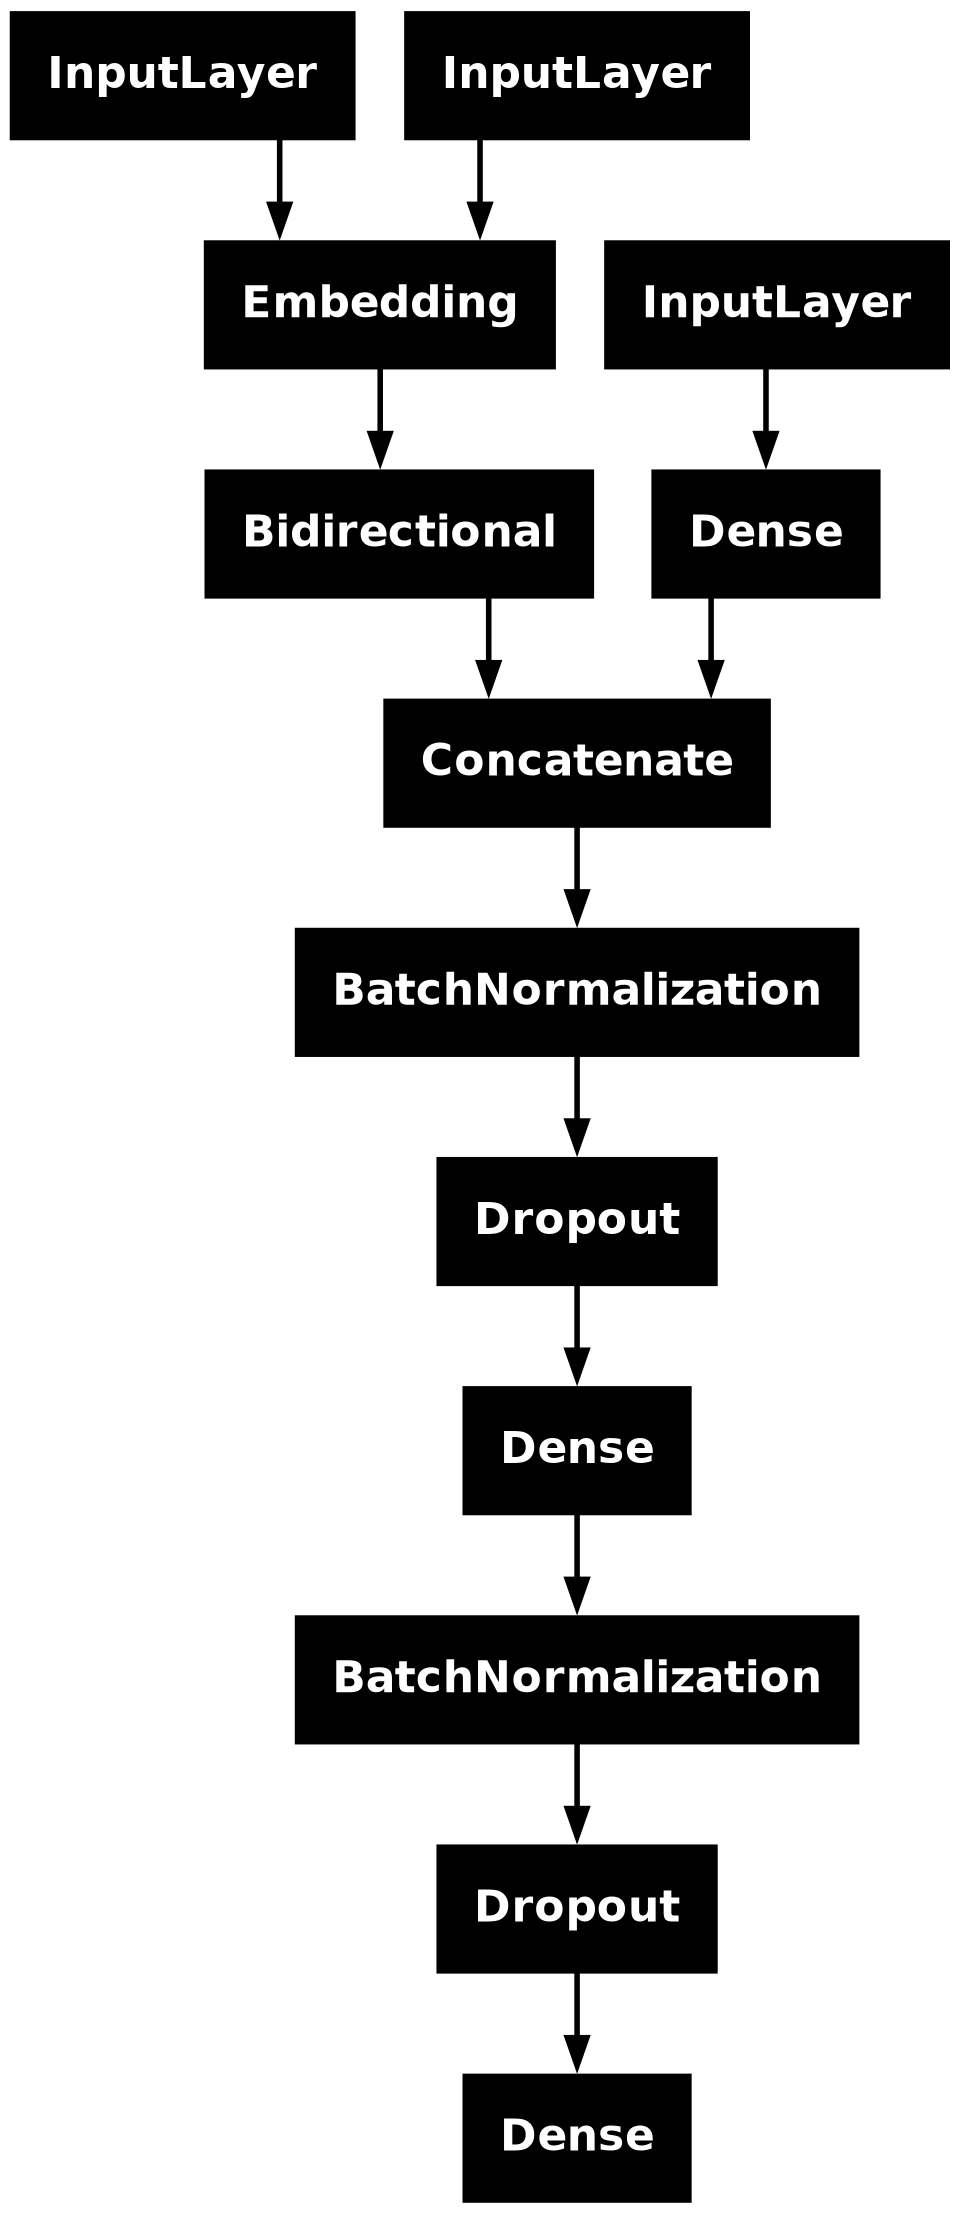

In [40]:
from keras.utils import plot_model
plot_model(model, to_file='model_lstm.png')
from IPython.display import Image
Image(filename='model_lstm.png')

In [44]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'lstm_model.{epoch:02d}-{val_loss:.6f}.weights.h5',verbose=1,save_best_only=True,
                               save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2, min_lr=0.00001, verbose=1)

In [45]:
history = model.fit([text_train_q1, text_train_q2, length_features_train], label_train,validation_data=([text_test_q1, text_test_q2, length_features_test], label_test),epochs=200, batch_size=1024,callbacks=[earlystopper, checkpointer, reduce_lr],verbose=1)

Epoch 1/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - acc: 0.6708 - loss: 0.6278
Epoch 1: val_loss improved from inf to 0.47301, saving model to lstm_model.01-0.473012.weights.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 136s 444ms/step - acc: 0.6710 - loss: 0.6275 - val_acc: 0.7540 - val_loss: 0.4730 - learning_rate: 0.0010
Epoch 2/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - acc: 0.7541 - loss: 0.4719
Epoch 2: val_loss improved from 0.47301 to 0.43991, saving model to lstm_model.02-0.439906.weights.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 121s 439ms/step - acc: 0.7541 - loss: 0.4719 - val_acc: 0.7754 - val_loss: 0.4399 - learning_rate: 0.0010
Epoch 3/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - acc: 0.7695 - loss: 0.4483
Epoch 3: val_loss improved from 0.43991 to 0.42651, saving model to lstm_model.03-0.426514.weights.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 122s 440ms/step - acc: 0.7695 - loss: 0.4483 - val_acc: 0.7827 - val_loss: 0.4265 - learning_rate: 0.0010
Epoch 4/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 

In [46]:
from tensorflow.keras.models import load_model
model.save('final_stm_model.h5')

In [47]:
min_val_loss = min(history.history["val_loss"])
min_train_loss = min(history.history["loss"])
max_val_acc = max(history.history["val_acc"])
max_train_acc = max(history.history["acc"])
print("min_train_loss=%g, min_val_loss=%g, max_train_acc=%g, max_val_acc=%g" % (min_train_loss,min_val_loss,max_train_acc,max_val_acc))

min_train_loss=0.325167, min_val_loss=0.356756, max_train_acc=0.848359, max_val_acc=0.831787


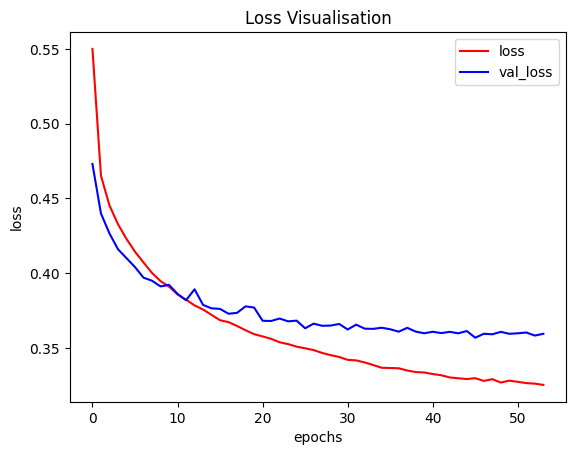

In [50]:
# epoch vs loss

plt.plot(history.history["loss"],color = 'red', label = 'loss')
plt.plot(history.history["val_loss"],color = 'blue', label = 'val_loss')
plt.title('Loss Visualisation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig('loss_lstm.pdf',dpi=1000)

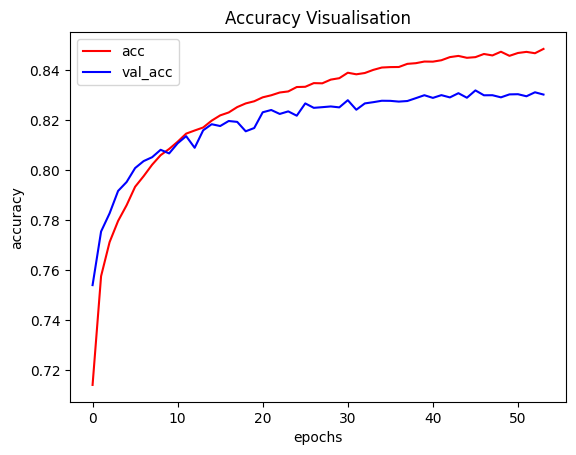

In [52]:
# epoch vs accuracy
plt.plot(history.history["acc"],color = 'red', label = 'acc')
plt.plot(history.history["val_acc"],color = 'blue', label = 'val_acc')
plt.title('Accuracy Visualisation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('acc_lstm.pdf',dpi=1000)

In [53]:
model_predictions = model.predict([text_test_q1, text_test_q2, length_features_test])

3791/3791 ━━━━━━━━━━━━━━━━━━━━ 378s 100ms/step


In [54]:
predictions = np.zeros_like(model_predictions)
predictions[np.arange(len(model_predictions)), model_predictions.argmax(1)] = 1

In [55]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(label_test,predictions))
accuracy = accuracy_score(label_test, predictions)
print("accuracy : ", accuracy)

              precision    recall  f1-score   support

           0       0.89      0.83      0.86     76350
           1       0.74      0.83      0.78     44937

   micro avg       0.83      0.83      0.83    121287
   macro avg       0.82      0.83      0.82    121287
weighted avg       0.84      0.83      0.83    121287
 samples avg       0.83      0.83      0.83    121287

accuracy :  0.8301301870769332


In [56]:
from sklearn.metrics import log_loss
log_loss_val= log_loss(label_test,model_predictions)
log_loss_val

0.3593576210541972